In [1]:
#import packages
import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import logging
import numpy as np
import copy

#custom classes
from classes import classes as cl
from functions import functions as fc
from functions import routing as rt
from functions import simulated_annealing as sa

plt.rcParams.update({'font.size': 22})
logging.basicConfig(filename="rrp_sa_optimization.log", level=logging.INFO)

Initiation

In [2]:
fc.print_log("Starting initiation")
#create empty dict
initiation_objects = {'dict_depots': '', 'dict_sites': '', 'dict_plants': '', 'dict_jobs': '', 'dict_tours': '', 'list_days': ''}
init_path = 'output/initial_solution'

objects = fc.initiate(initiation_objects,init_path,'final')

#load objects
list_days = objects['list_days']
dict_depots = objects['dict_depots']
dict_sites = objects['dict_sites']
dict_plants = objects['dict_plants']
dict_jobs = objects['dict_jobs']
dict_tours = objects['dict_tours']

#also create lists for convenience
list_depots = [dict_depots[element] for element in dict_depots]
list_sites = [dict_sites[element] for element in dict_sites]
list_plants = [dict_plants[element] for element in dict_plants]
list_jobs = [dict_jobs[element] for element in dict_jobs]
list_tours  = [dict_tours[element] for element in dict_tours]


fc.print_log("Done with initiation")

Starting initiation- t: 00:04:24
Starting initiation at 00:04:24- t: 00:04:24
Done with initiation- t: 00:04:25


In the first stage only one depot ist handled, so moves so its all about dropoff and pickup dates

In [3]:
#ov tours
for depot in dict_depots:
    total_tasks = 0
    total_distance = 0
    for day in list_days:
        total_tasks += dict_tours[depot][day].total_tasks
        total_distance += dict_tours[depot][day].distance
    print("Depot: {}, tasks: {} - distance: {}".format(depot,total_tasks,total_distance))

print("done here")

Depot: Neuherberg, tasks: 25454 - distance: 4547134.5148212565
Depot: Lauterhofen, tasks: 14329 - distance: 2151298.5445965845
Depot: Altbach, tasks: 5534 - distance: 648999.0083624776
Depot: Deisslingen, tasks: 0 - distance: 0
Depot: Bollschweil, tasks: 1586 - distance: 167723.71699792094
Depot: Lampertheim, tasks: 5872 - distance: 1059256.2914196497
Depot: Neuss, tasks: 19062 - distance: 2374315.453137417
Depot: Embsen, tasks: 9216 - distance: 1121736.368534145
Depot: Rottleberode, tasks: 25304 - distance: 6393335.900862845
Depot: Fenne, tasks: 0 - distance: 0
Depot: Castrop, tasks: 0 - distance: 0
Depot: Perl, tasks: 0 - distance: 0
Depot: Gnetsch, tasks: 0 - distance: 0
Depot: Vogelsdorf, tasks: 0 - distance: 0
Depot: Sukow, tasks: 0 - distance: 0
done here


start here
Start Inital Solution Plot- t: 00:04:25
Done with  Inital Solution Plot- t: 00:04:33


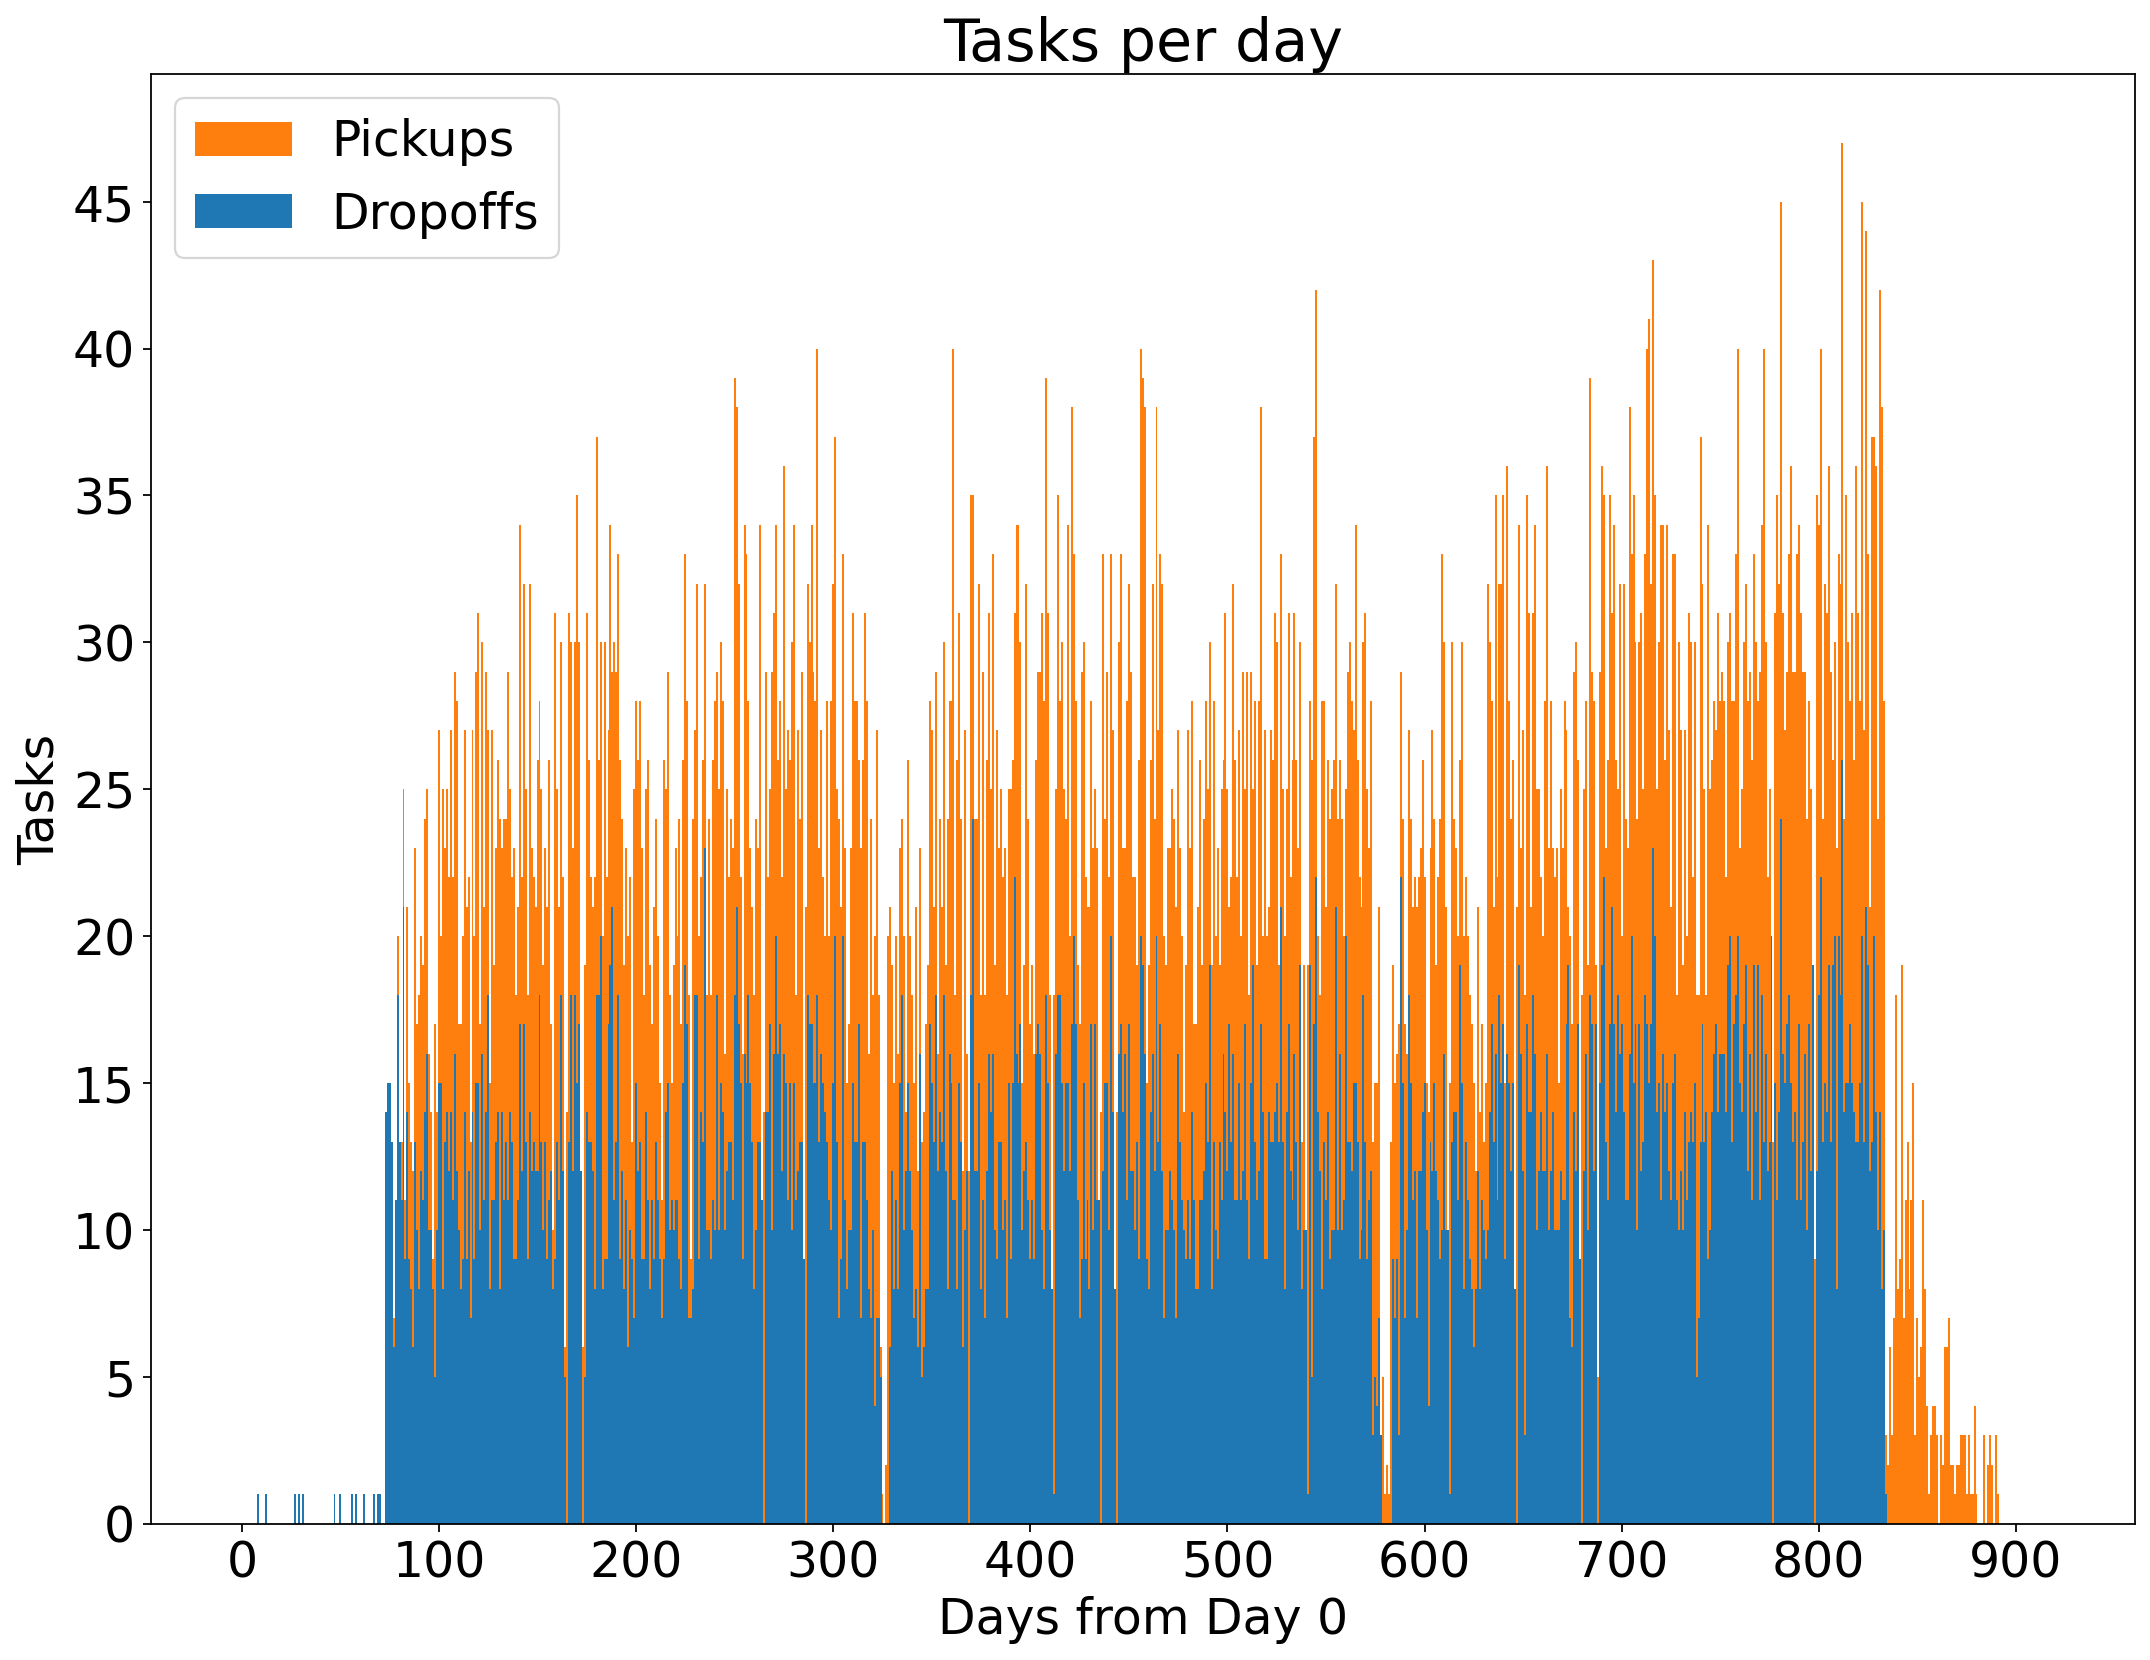

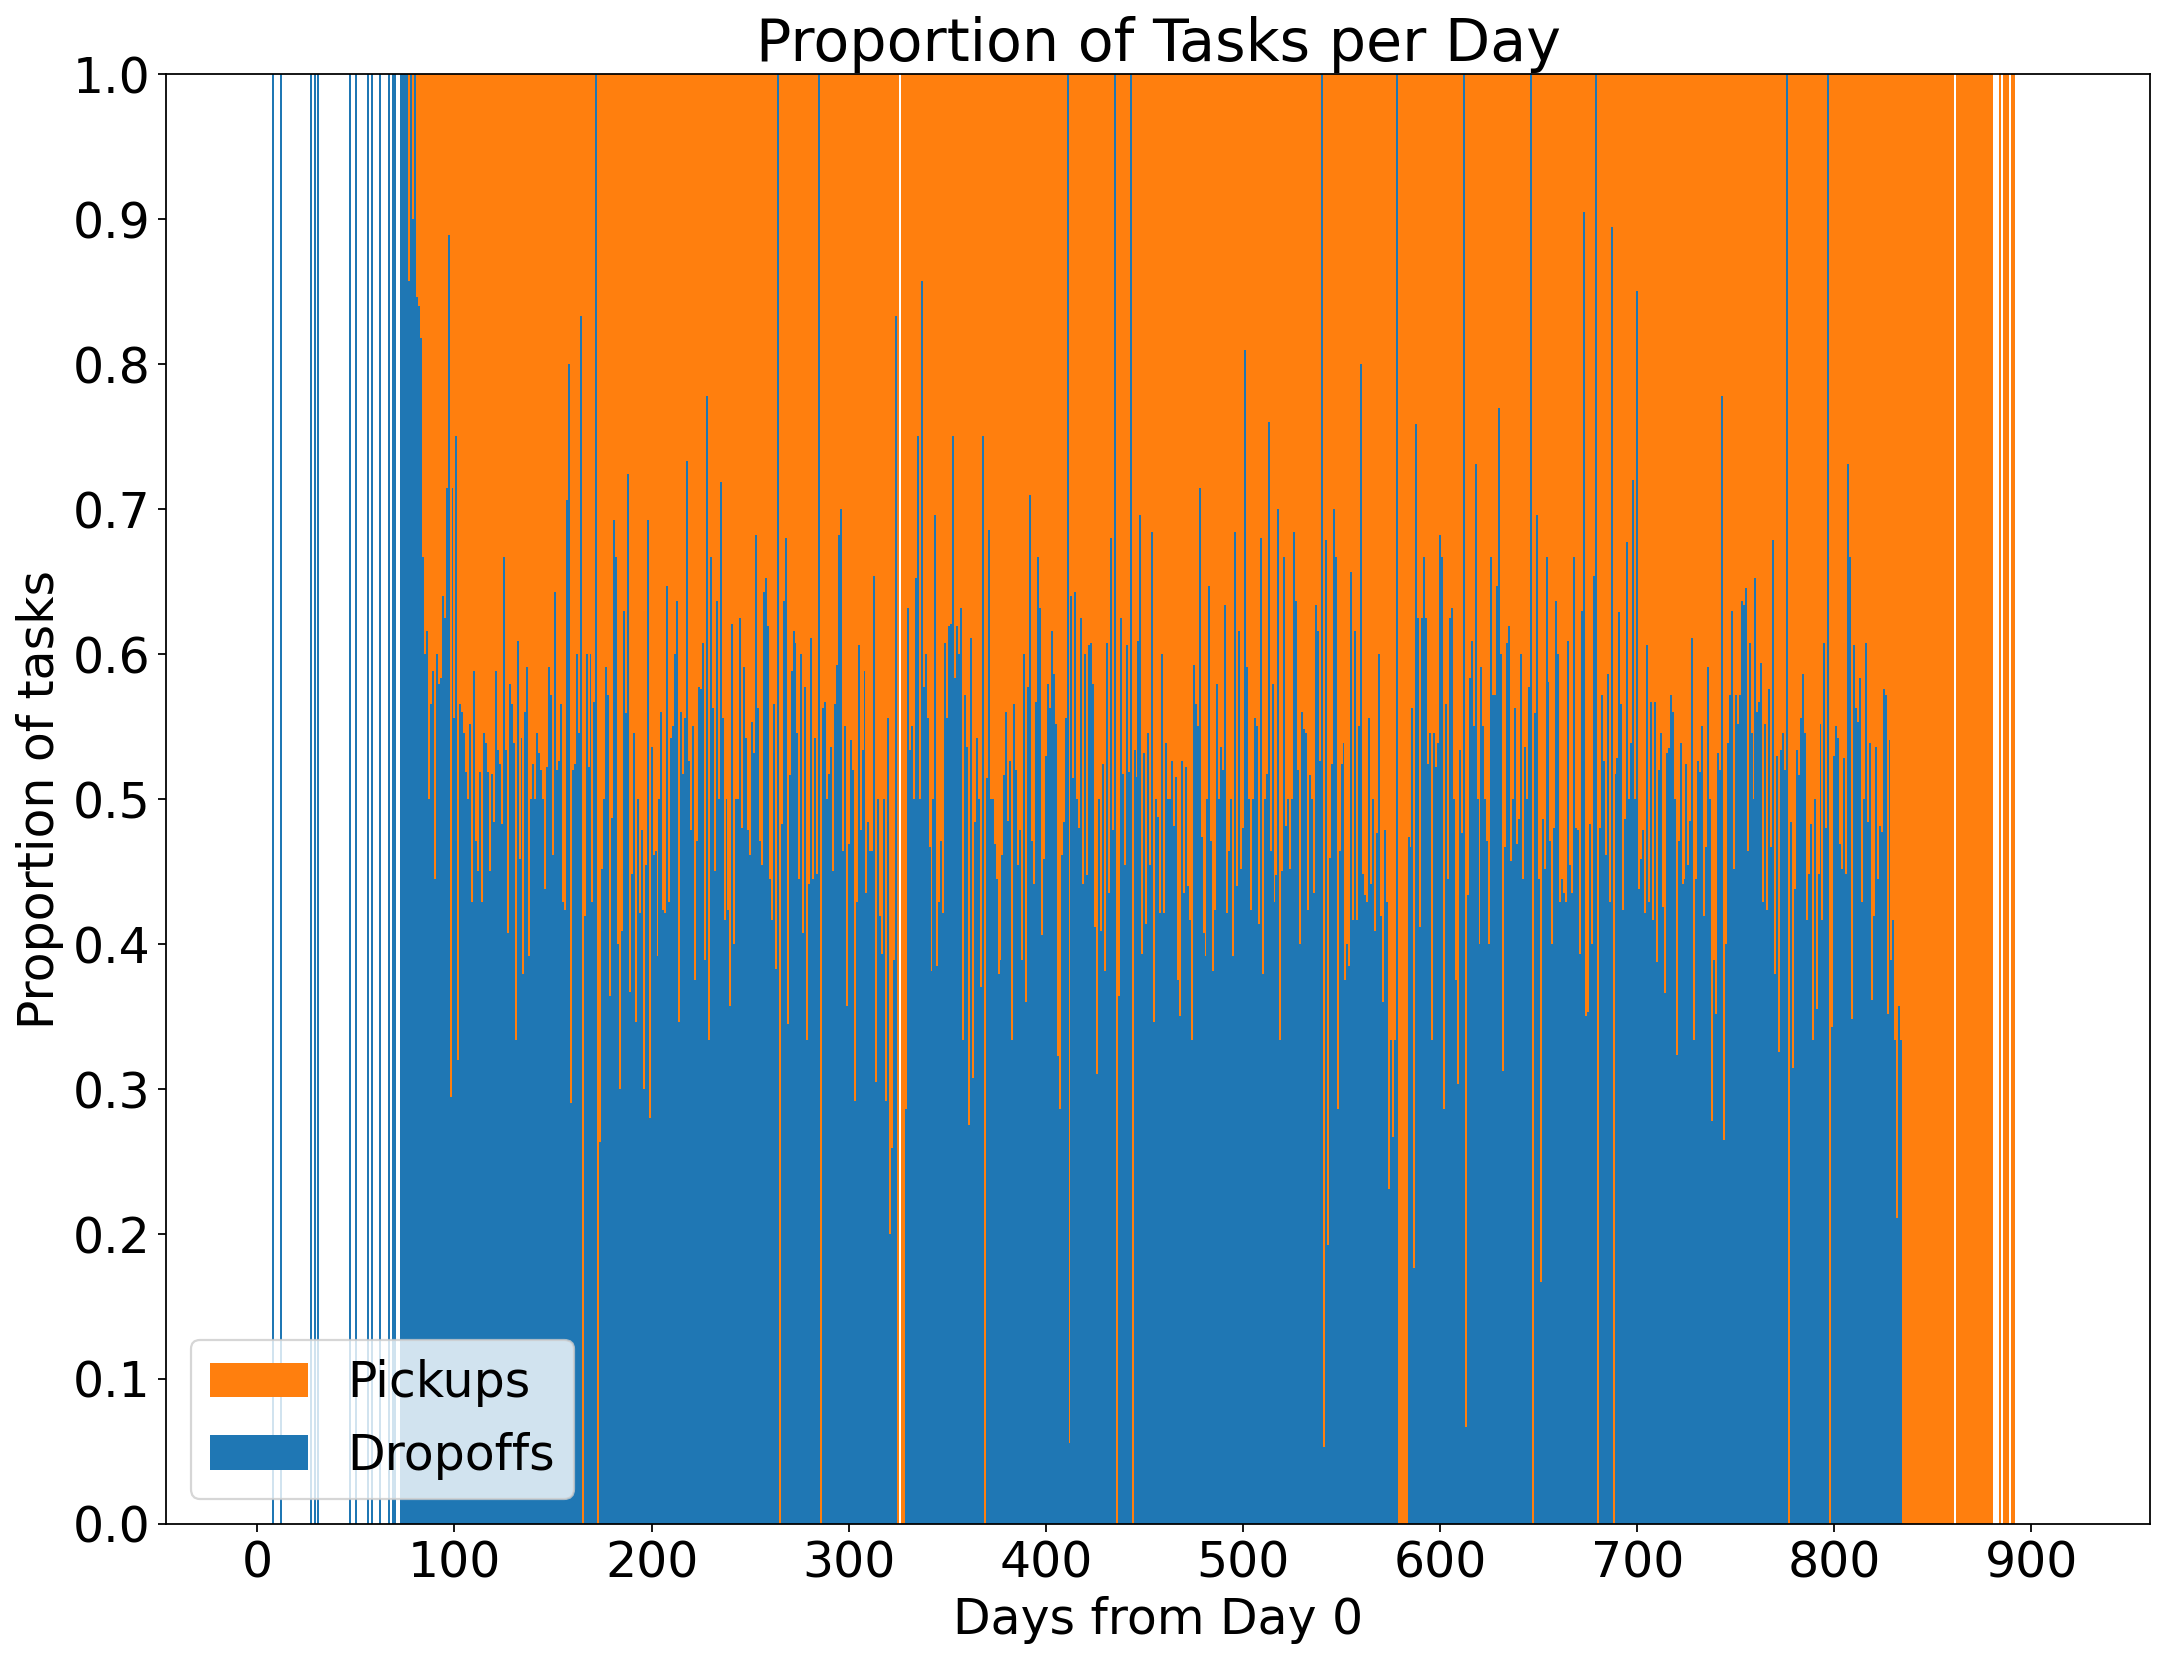

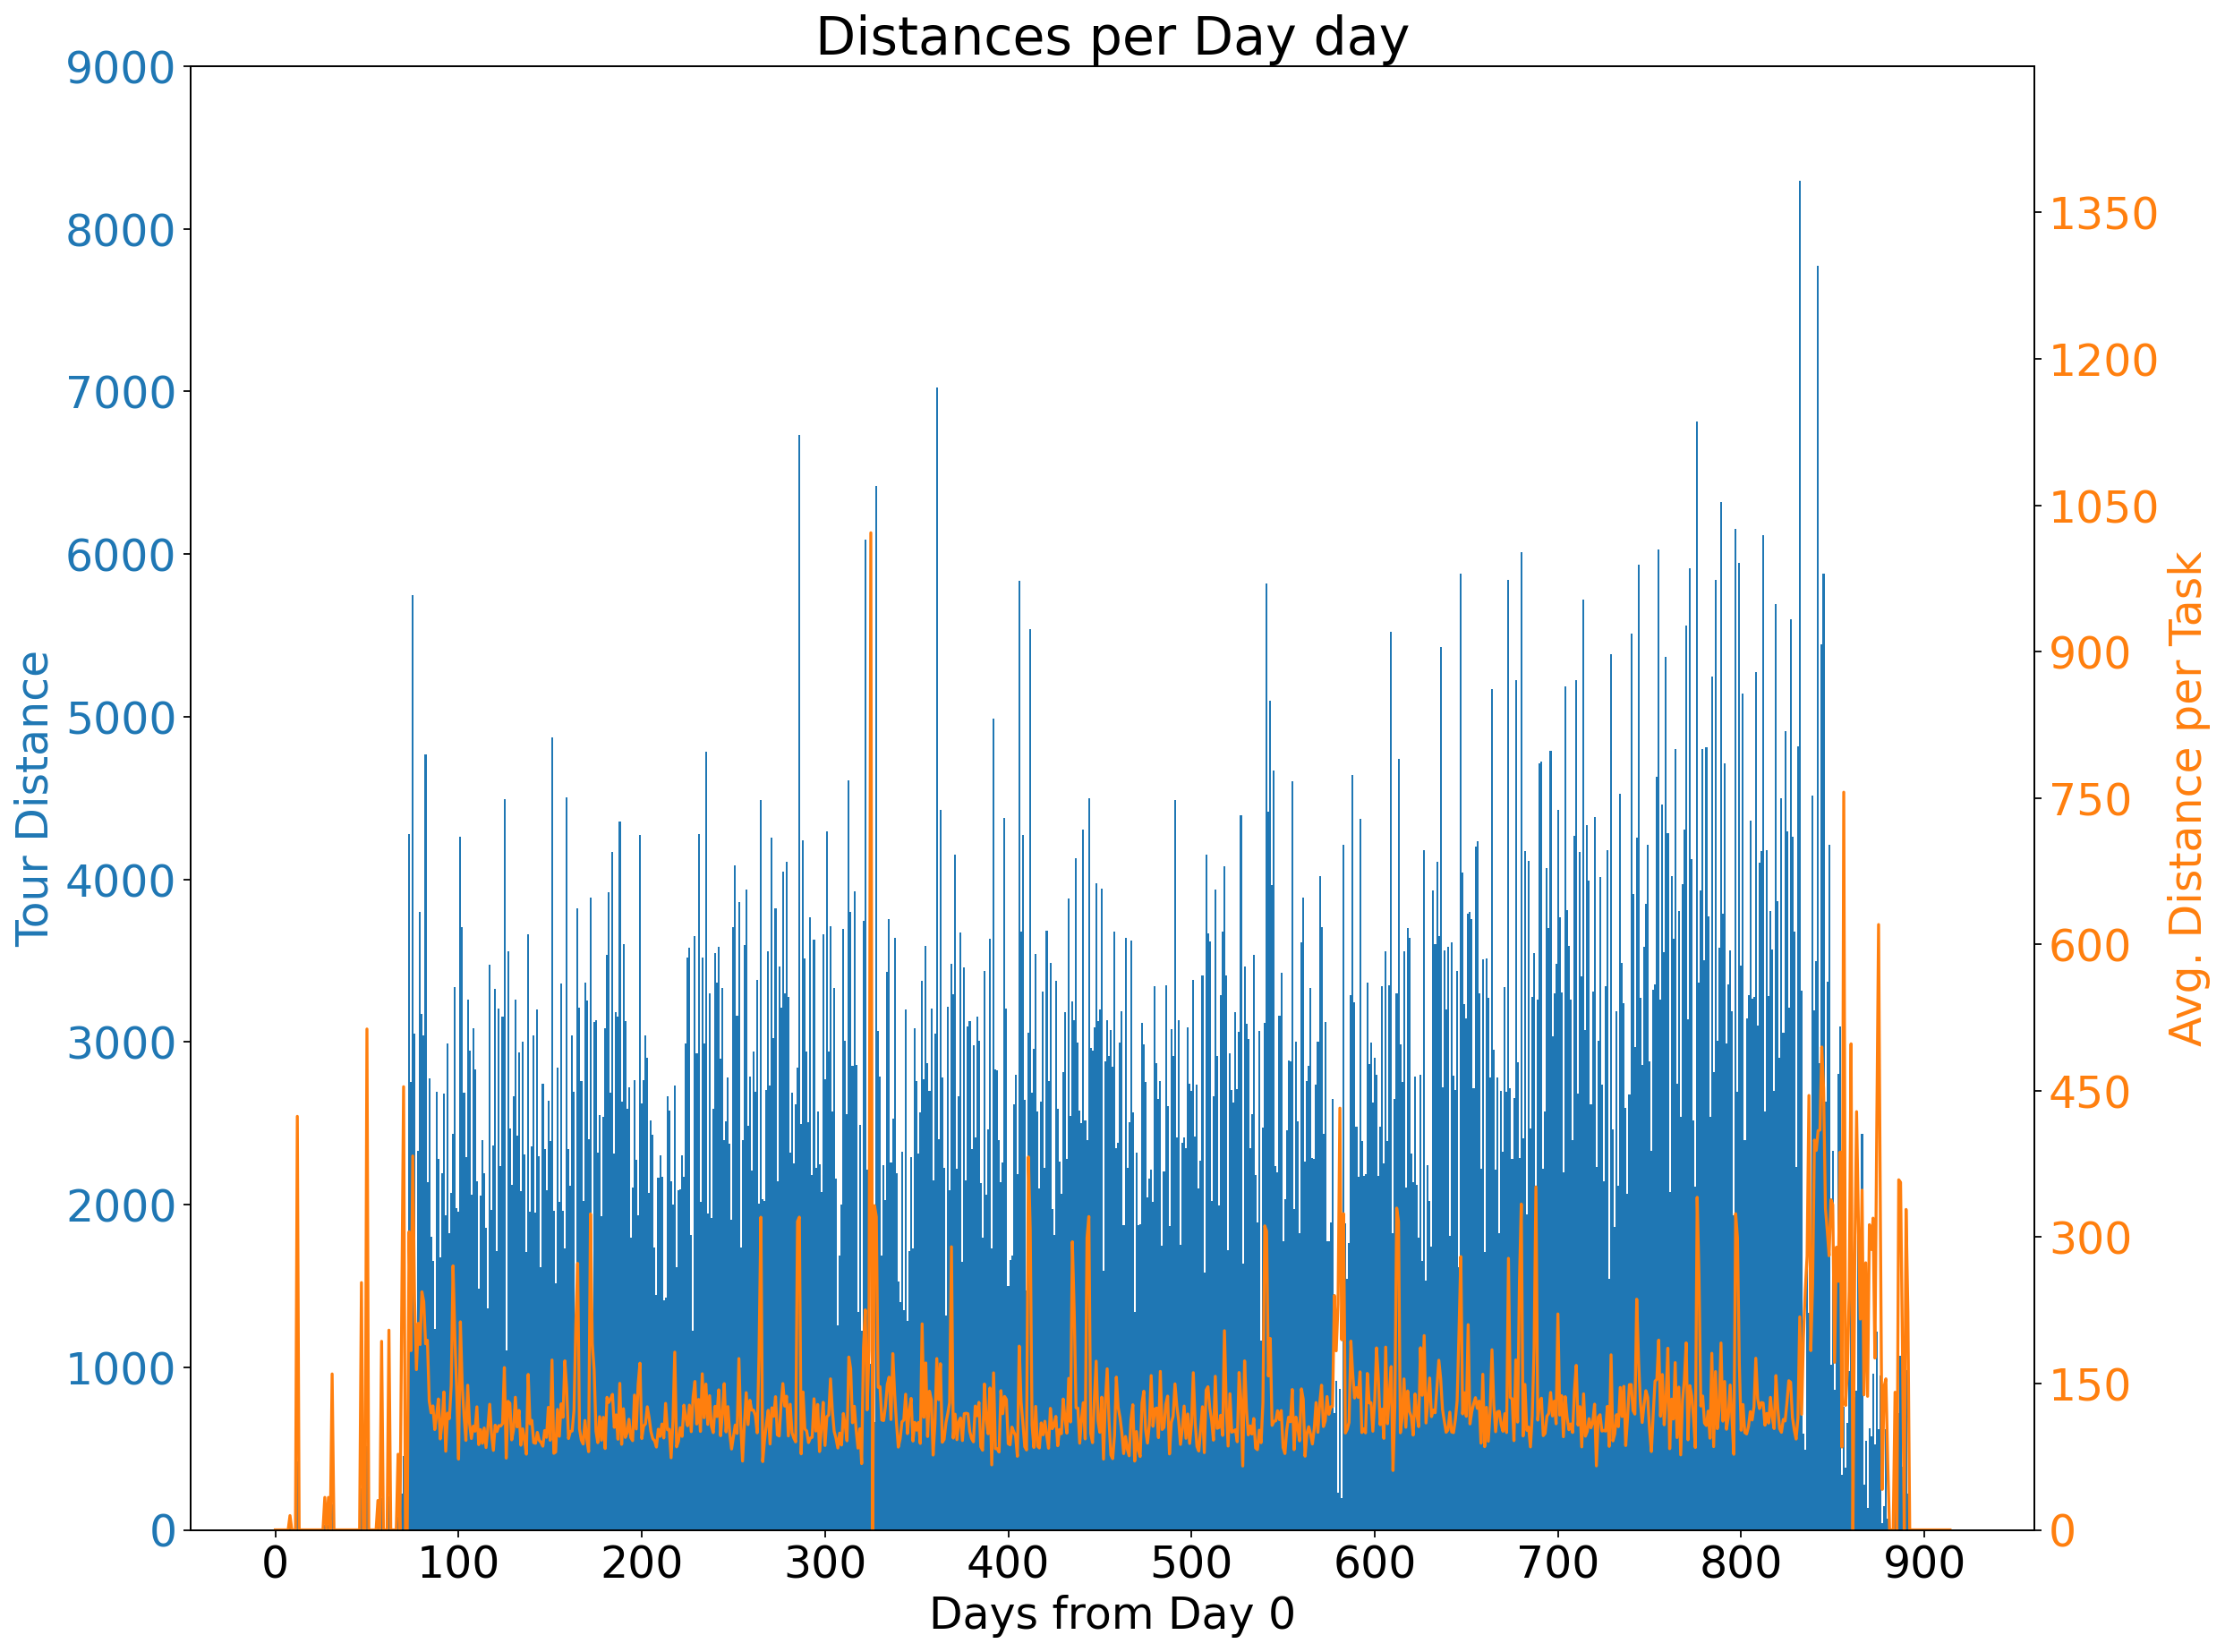

In [4]:
print("start here")
fc.print_log("Start Inital Solution Plot")

#only work with one depot
temp_depot = dict_depots['Neuss']
list_depots = [temp_depot]
dict_depots = {'Neuss': temp_depot}



solution_initial = cl.Solution(temp_depot,dict_tours,list_days)

solution_initial.plot_tasks(50)
solution_initial.plot_task_proportion()
solution_initial.plot_distances(10000,1500)

fc.print_log("Done with  Inital Solution Plot")


After having a look at the inital solution, start optimizing

Stage 1: Try to level out the proportions between dropoff and pickup on eatch job

Start with Stage 1- t: 00:04:33
Start deep copy- t: 00:04:33
Done with deep copy- t: 00:04:33
Start Moves- t: 00:04:33
Final: Iterations: 22 - Moves: 1288- t: 00:06:11                       
Done with Moves- t: 00:06:11
Done with Stage 1- t: 00:06:23


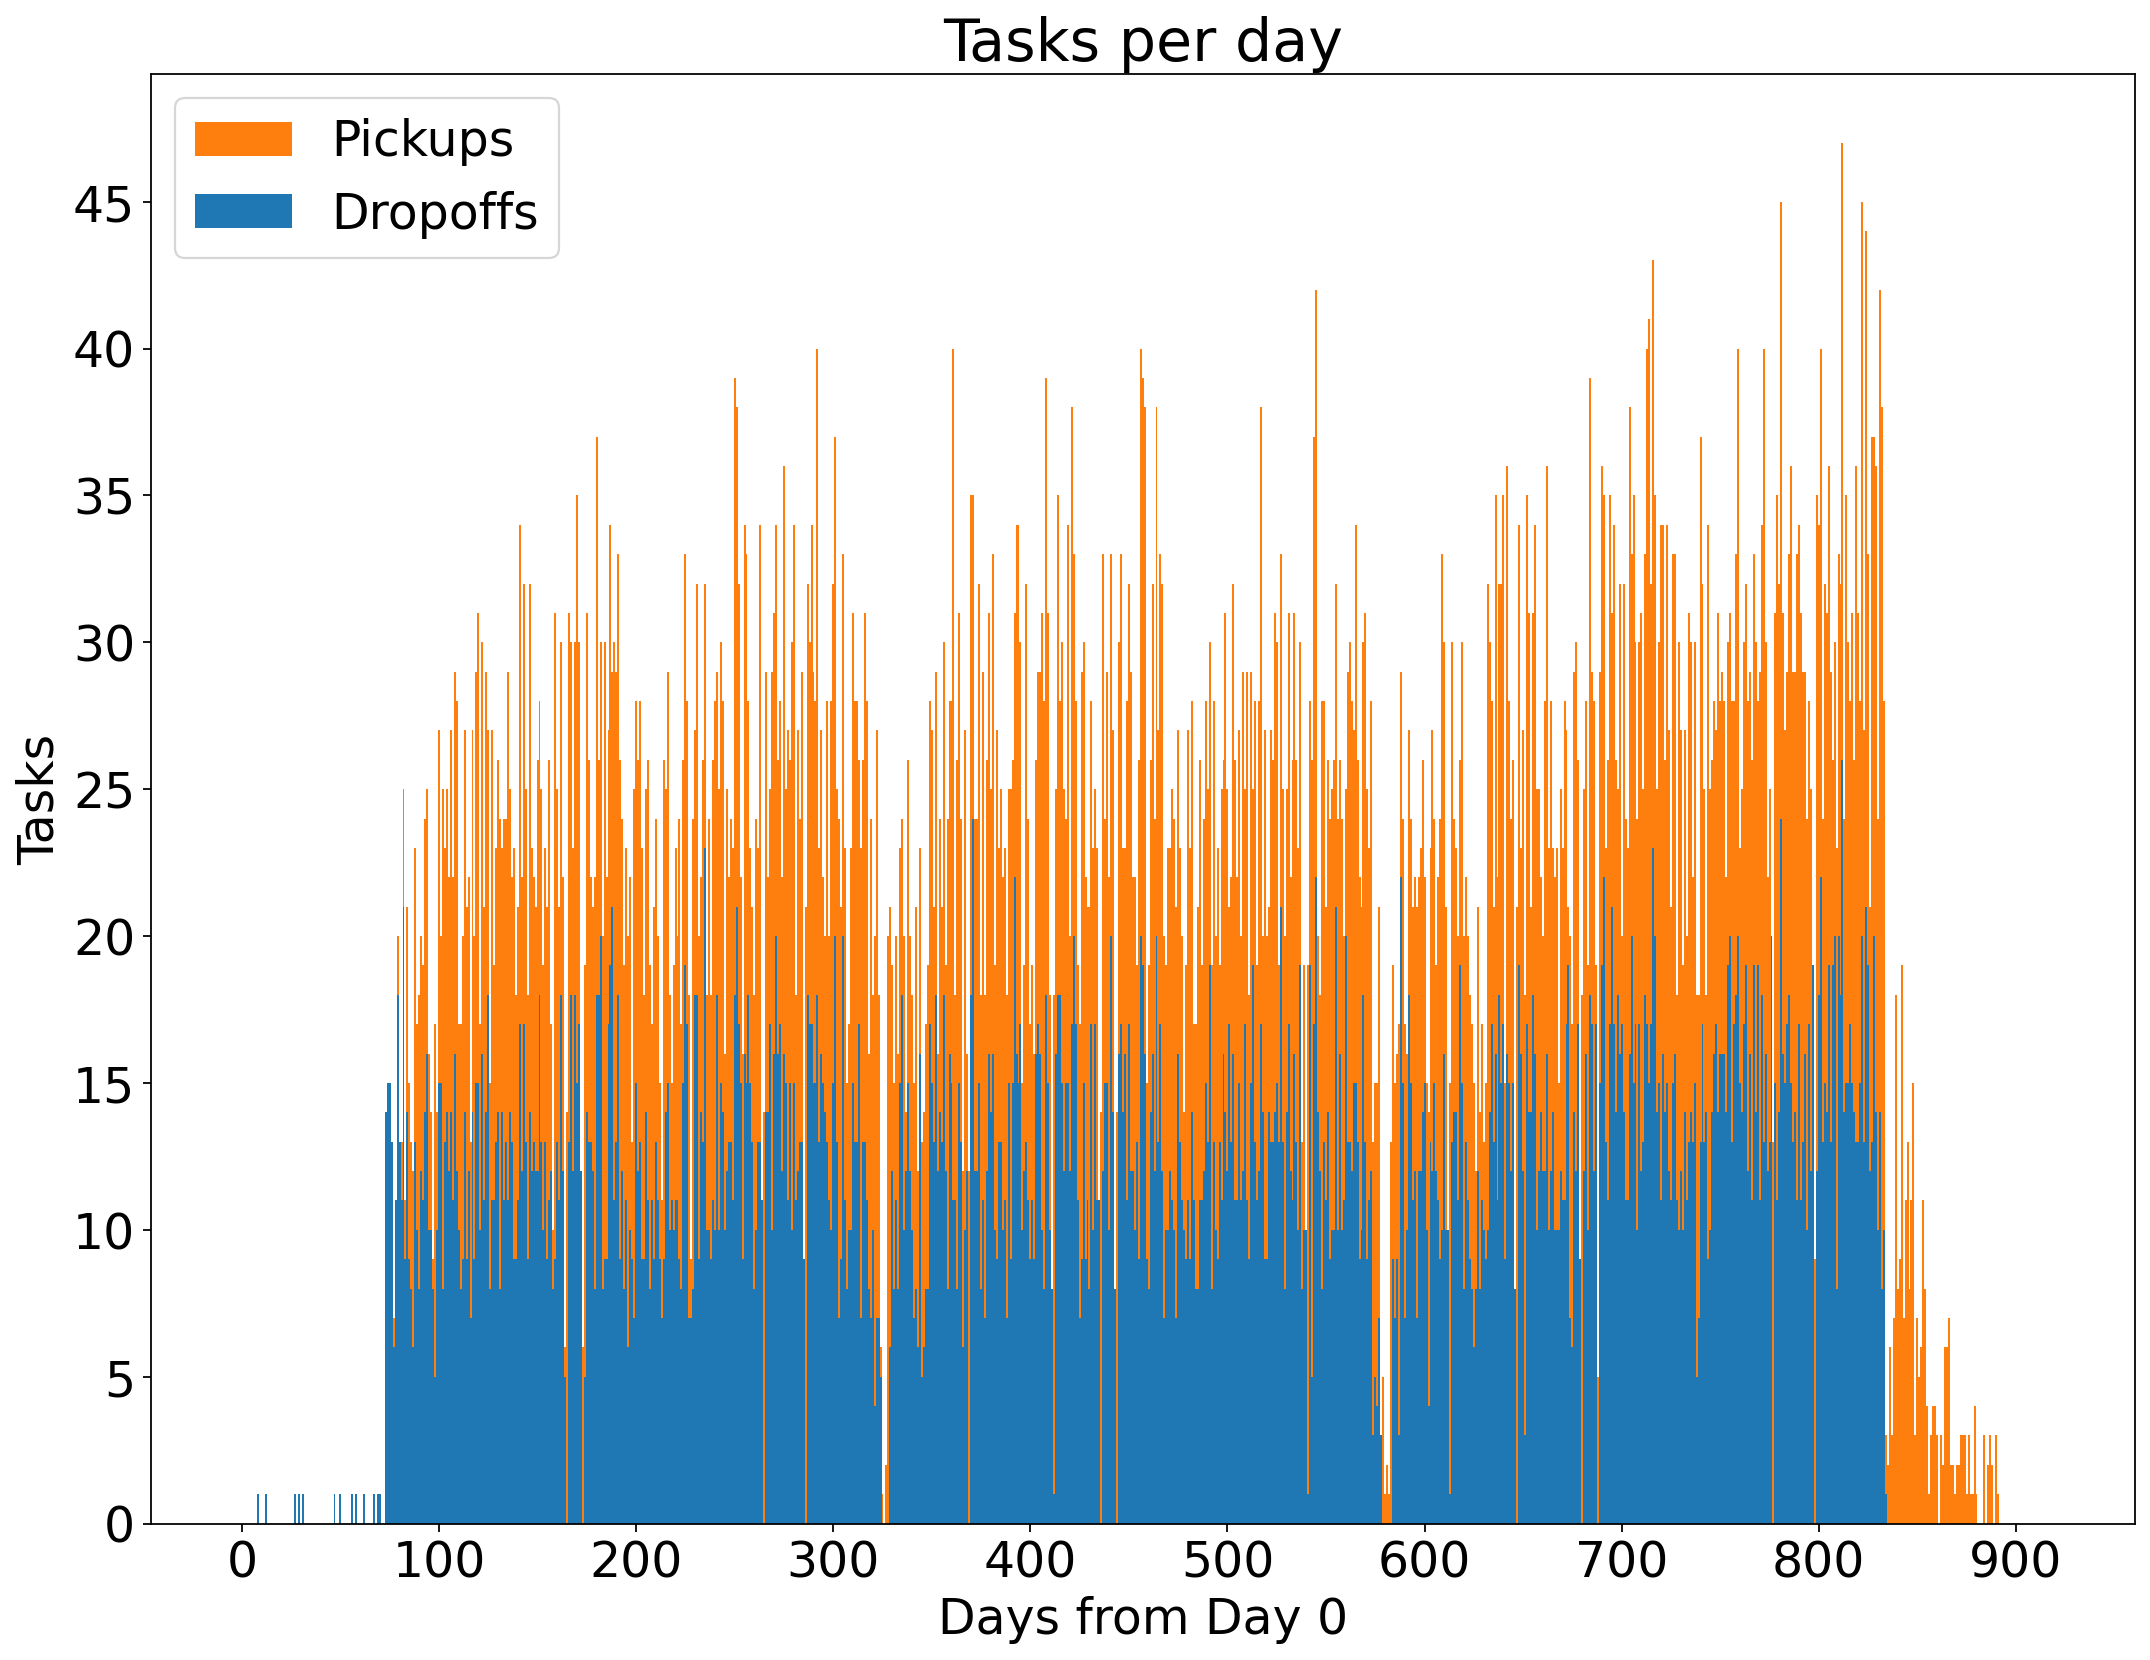

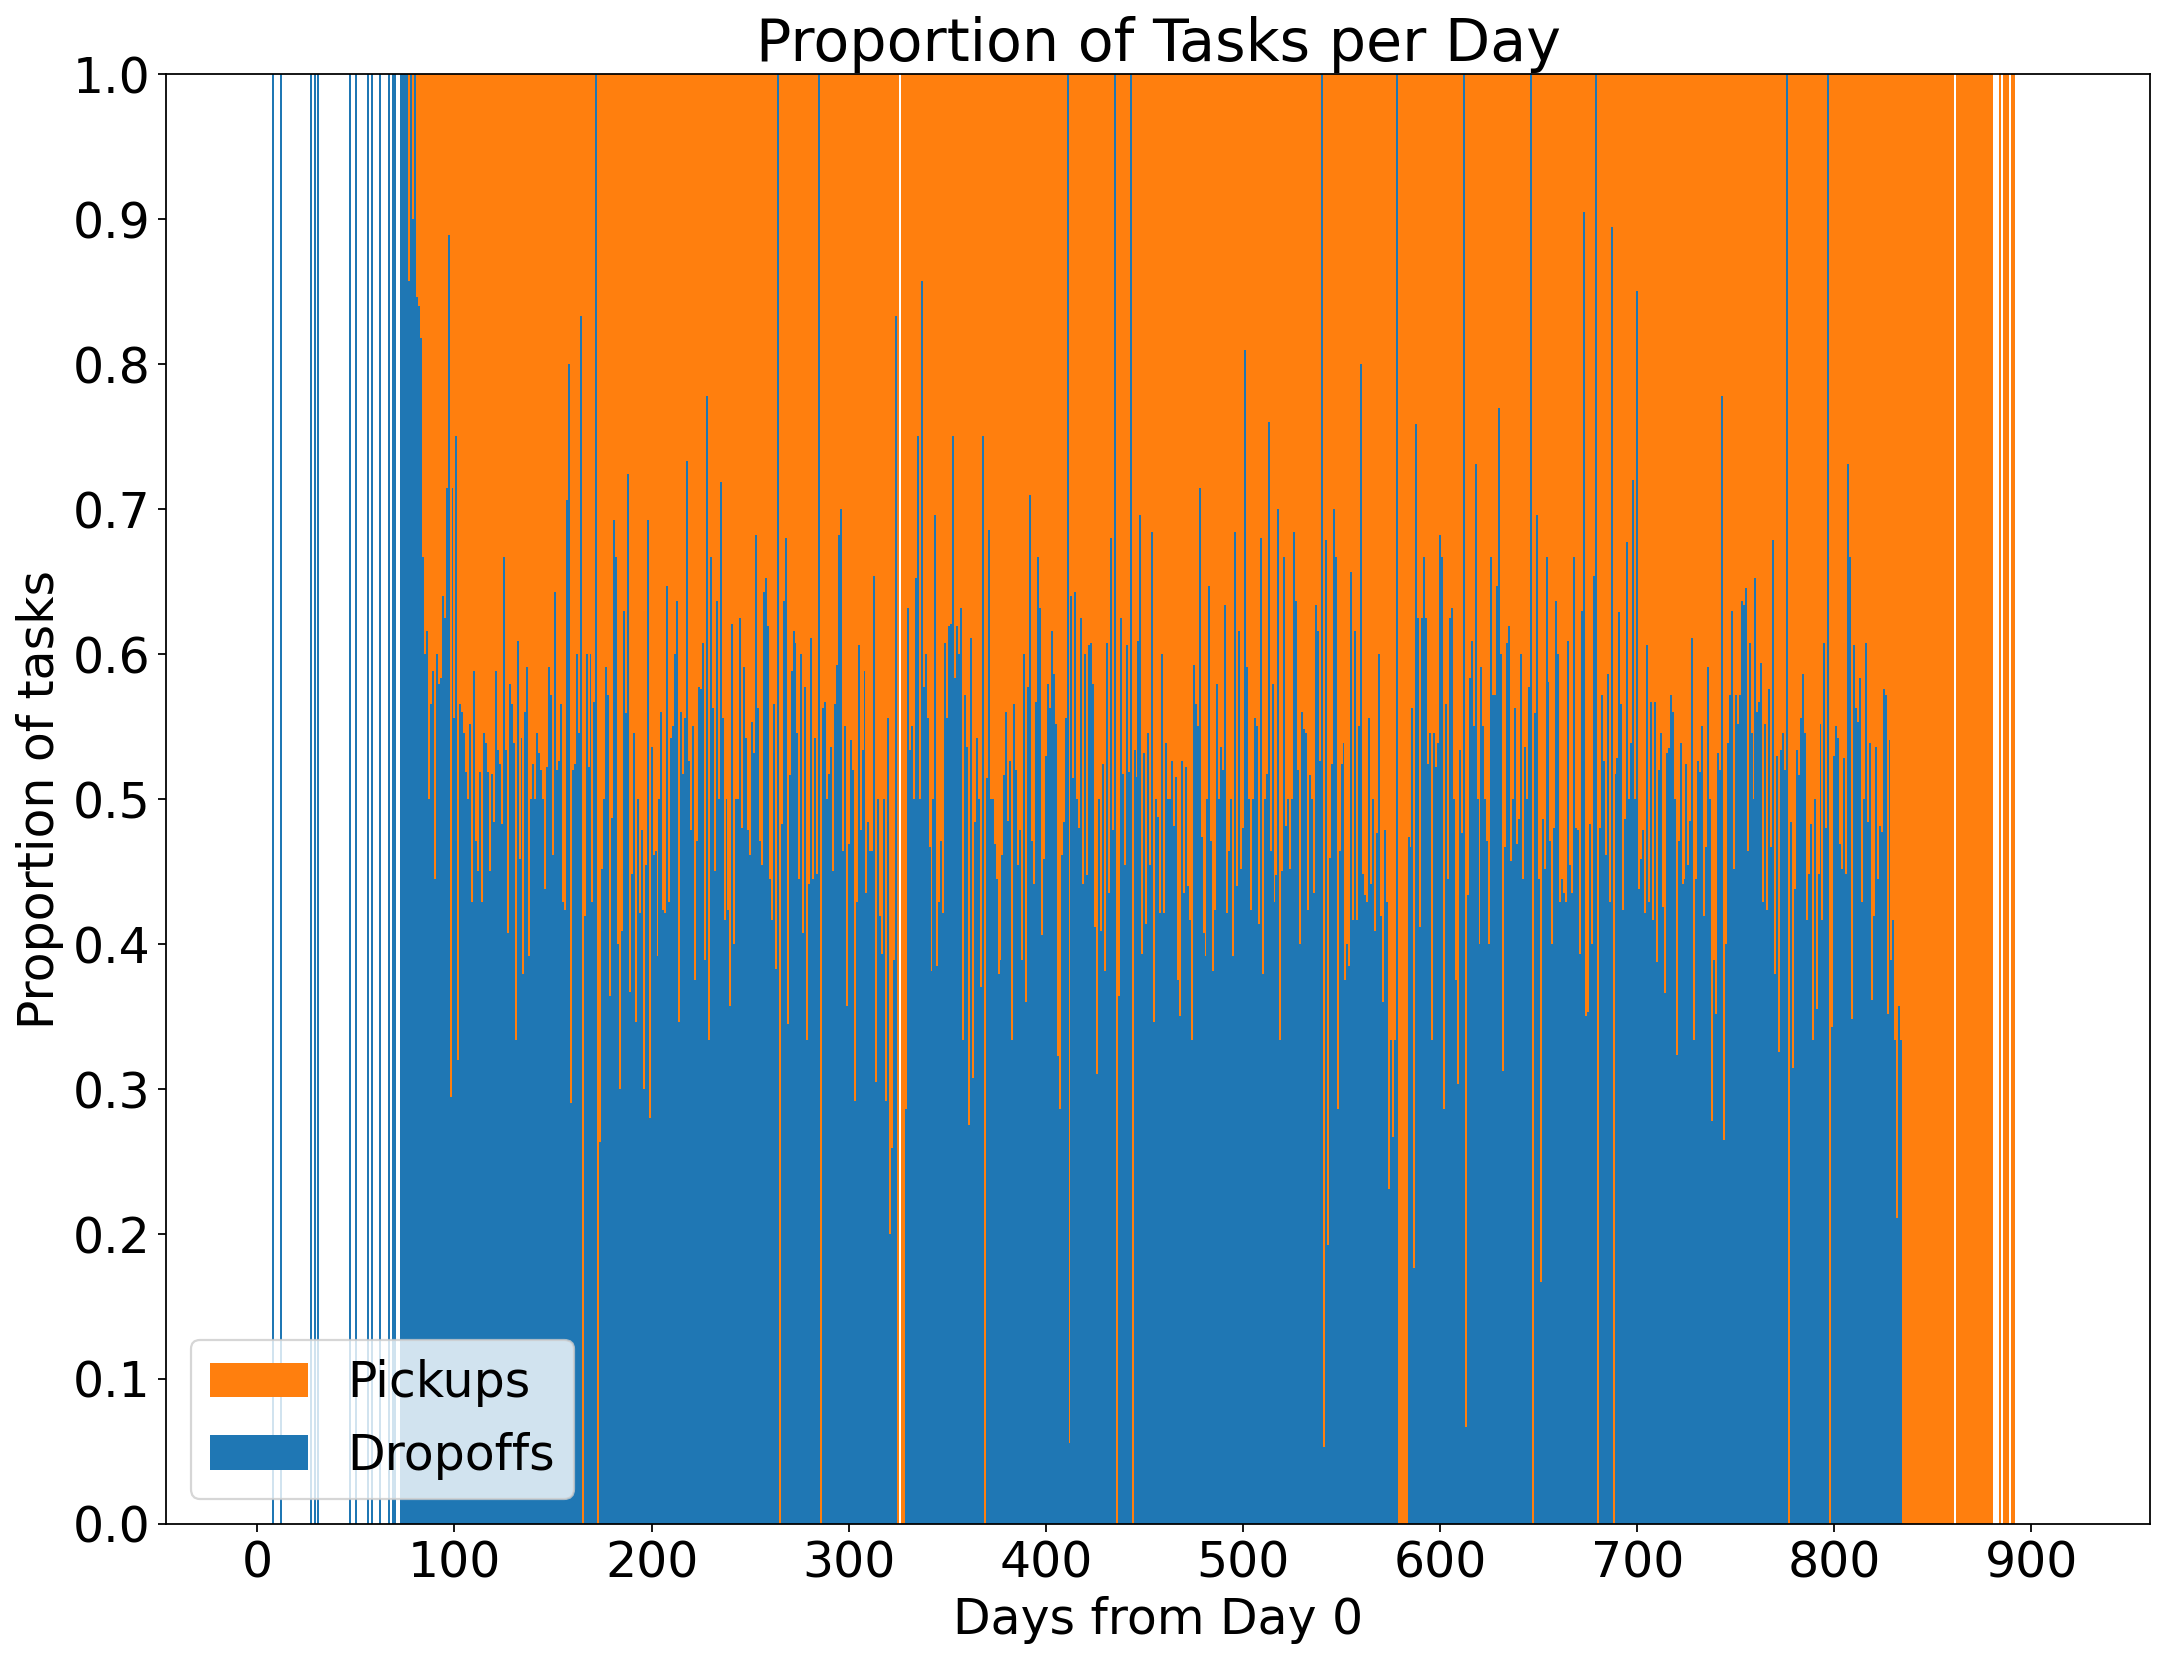

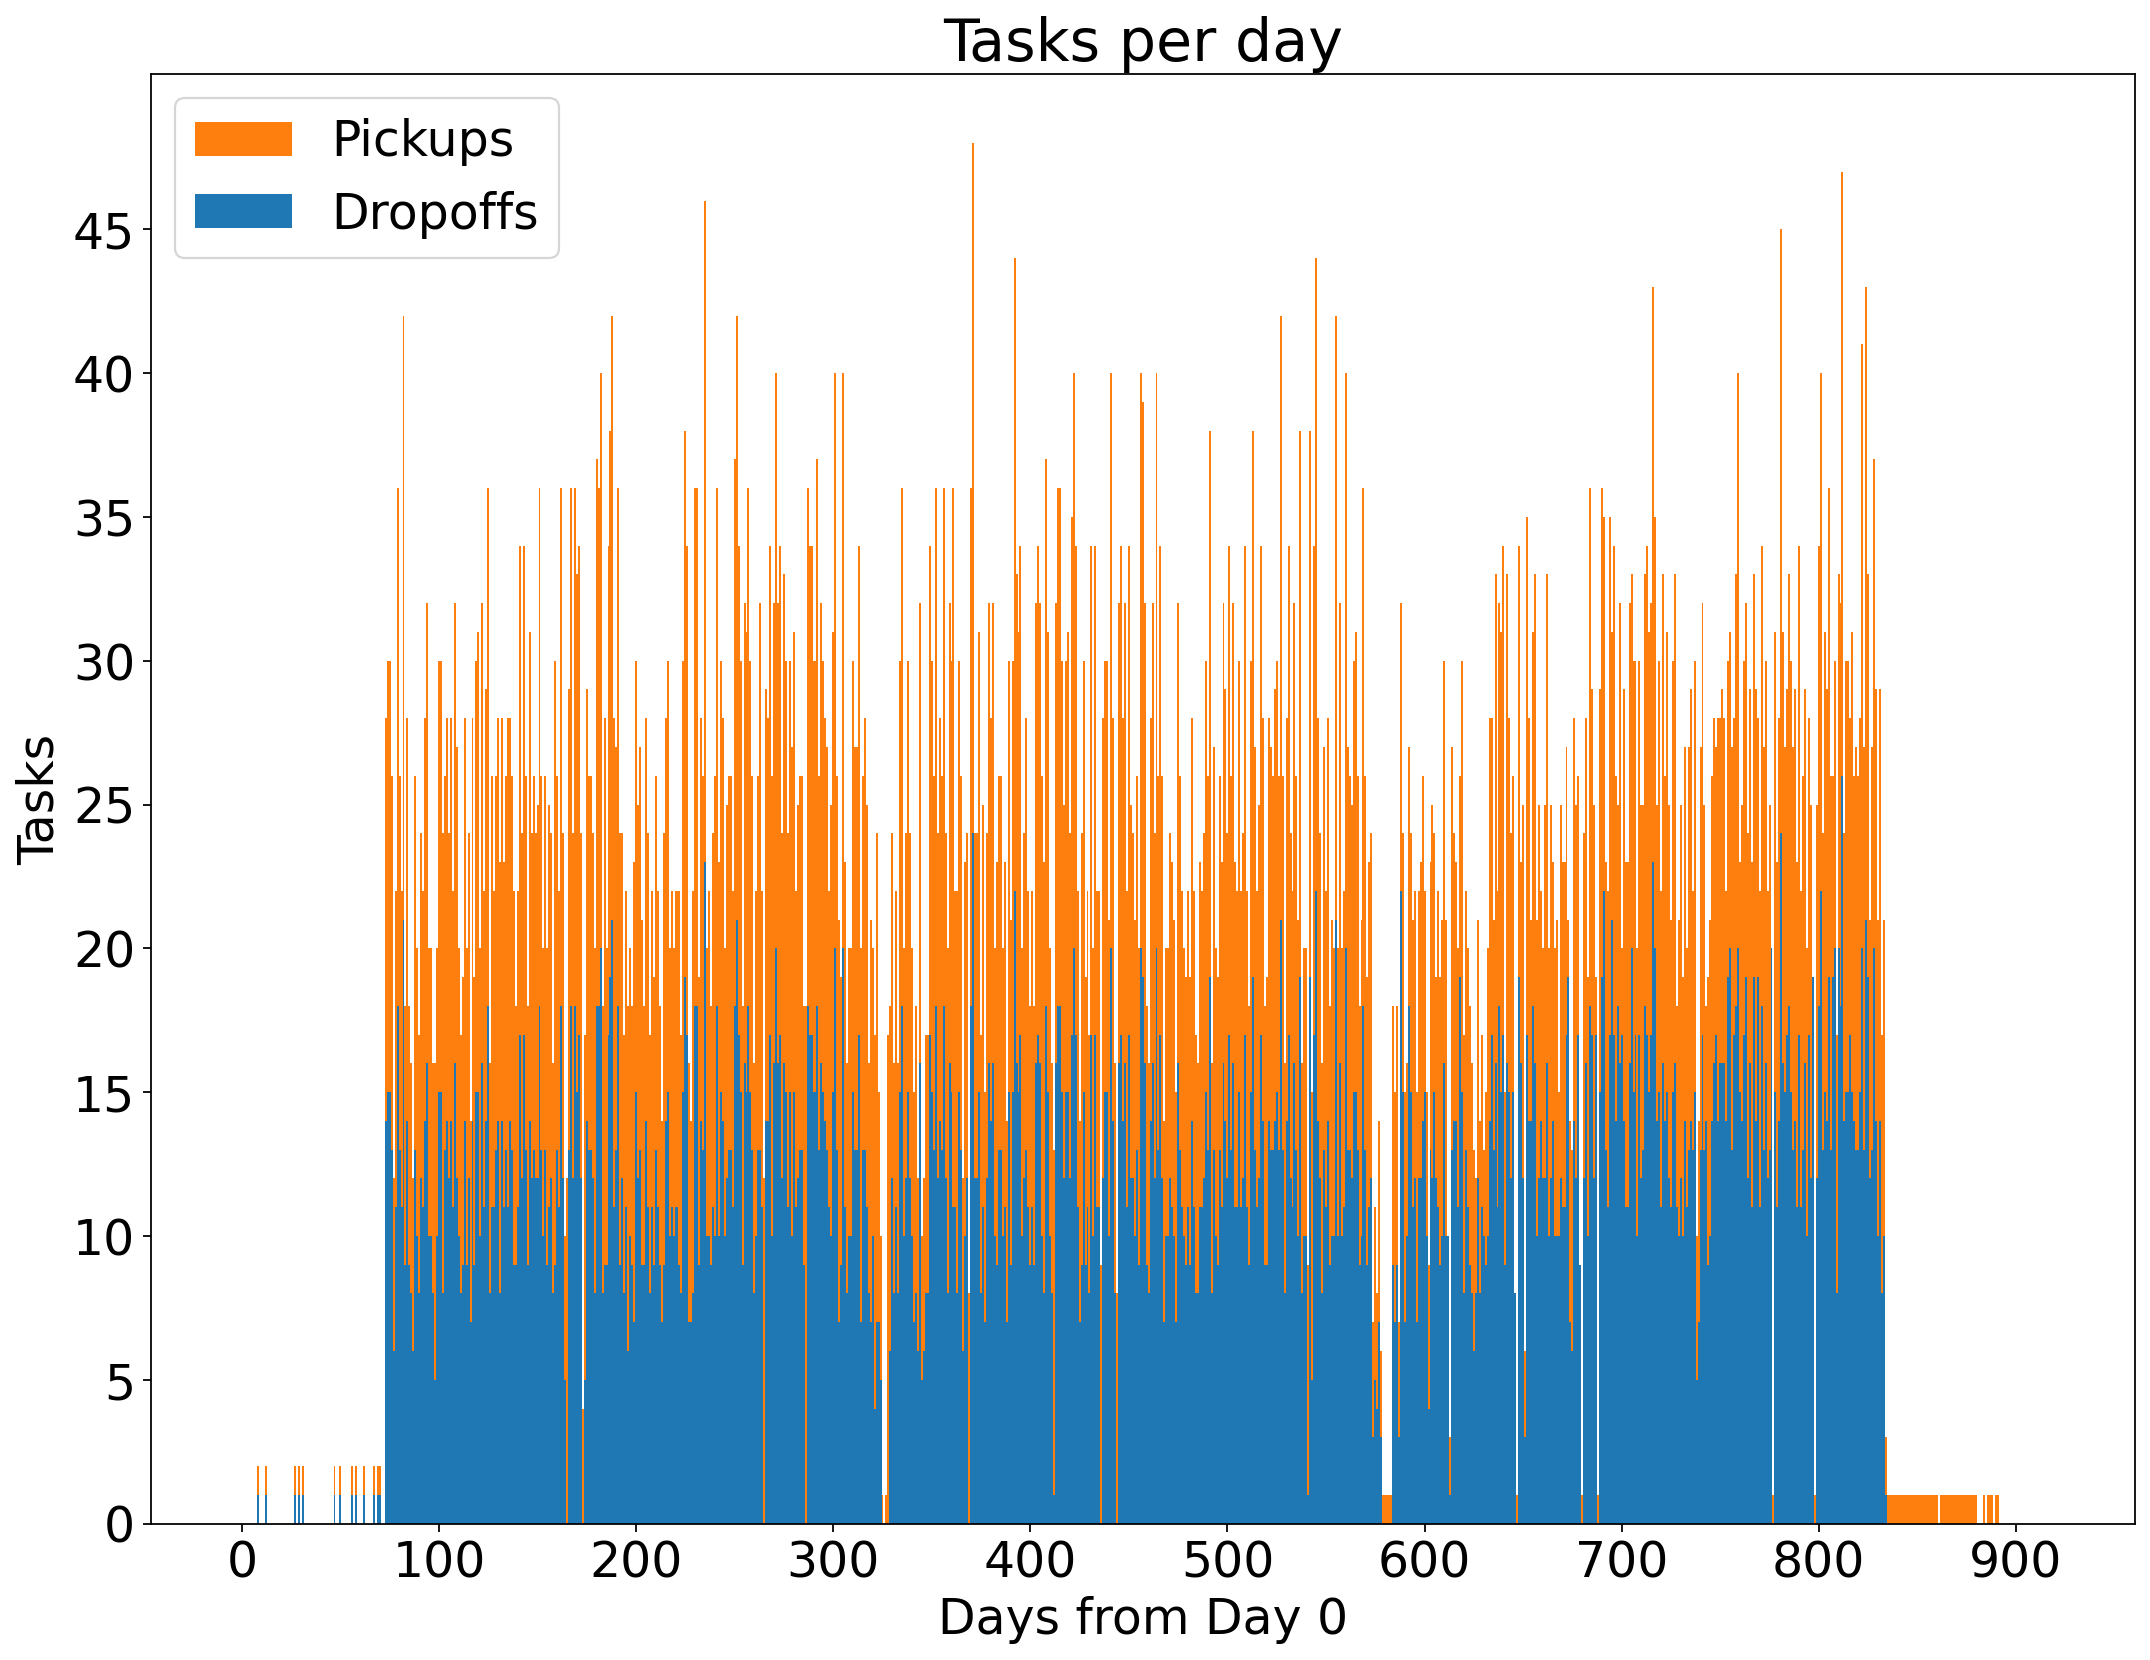

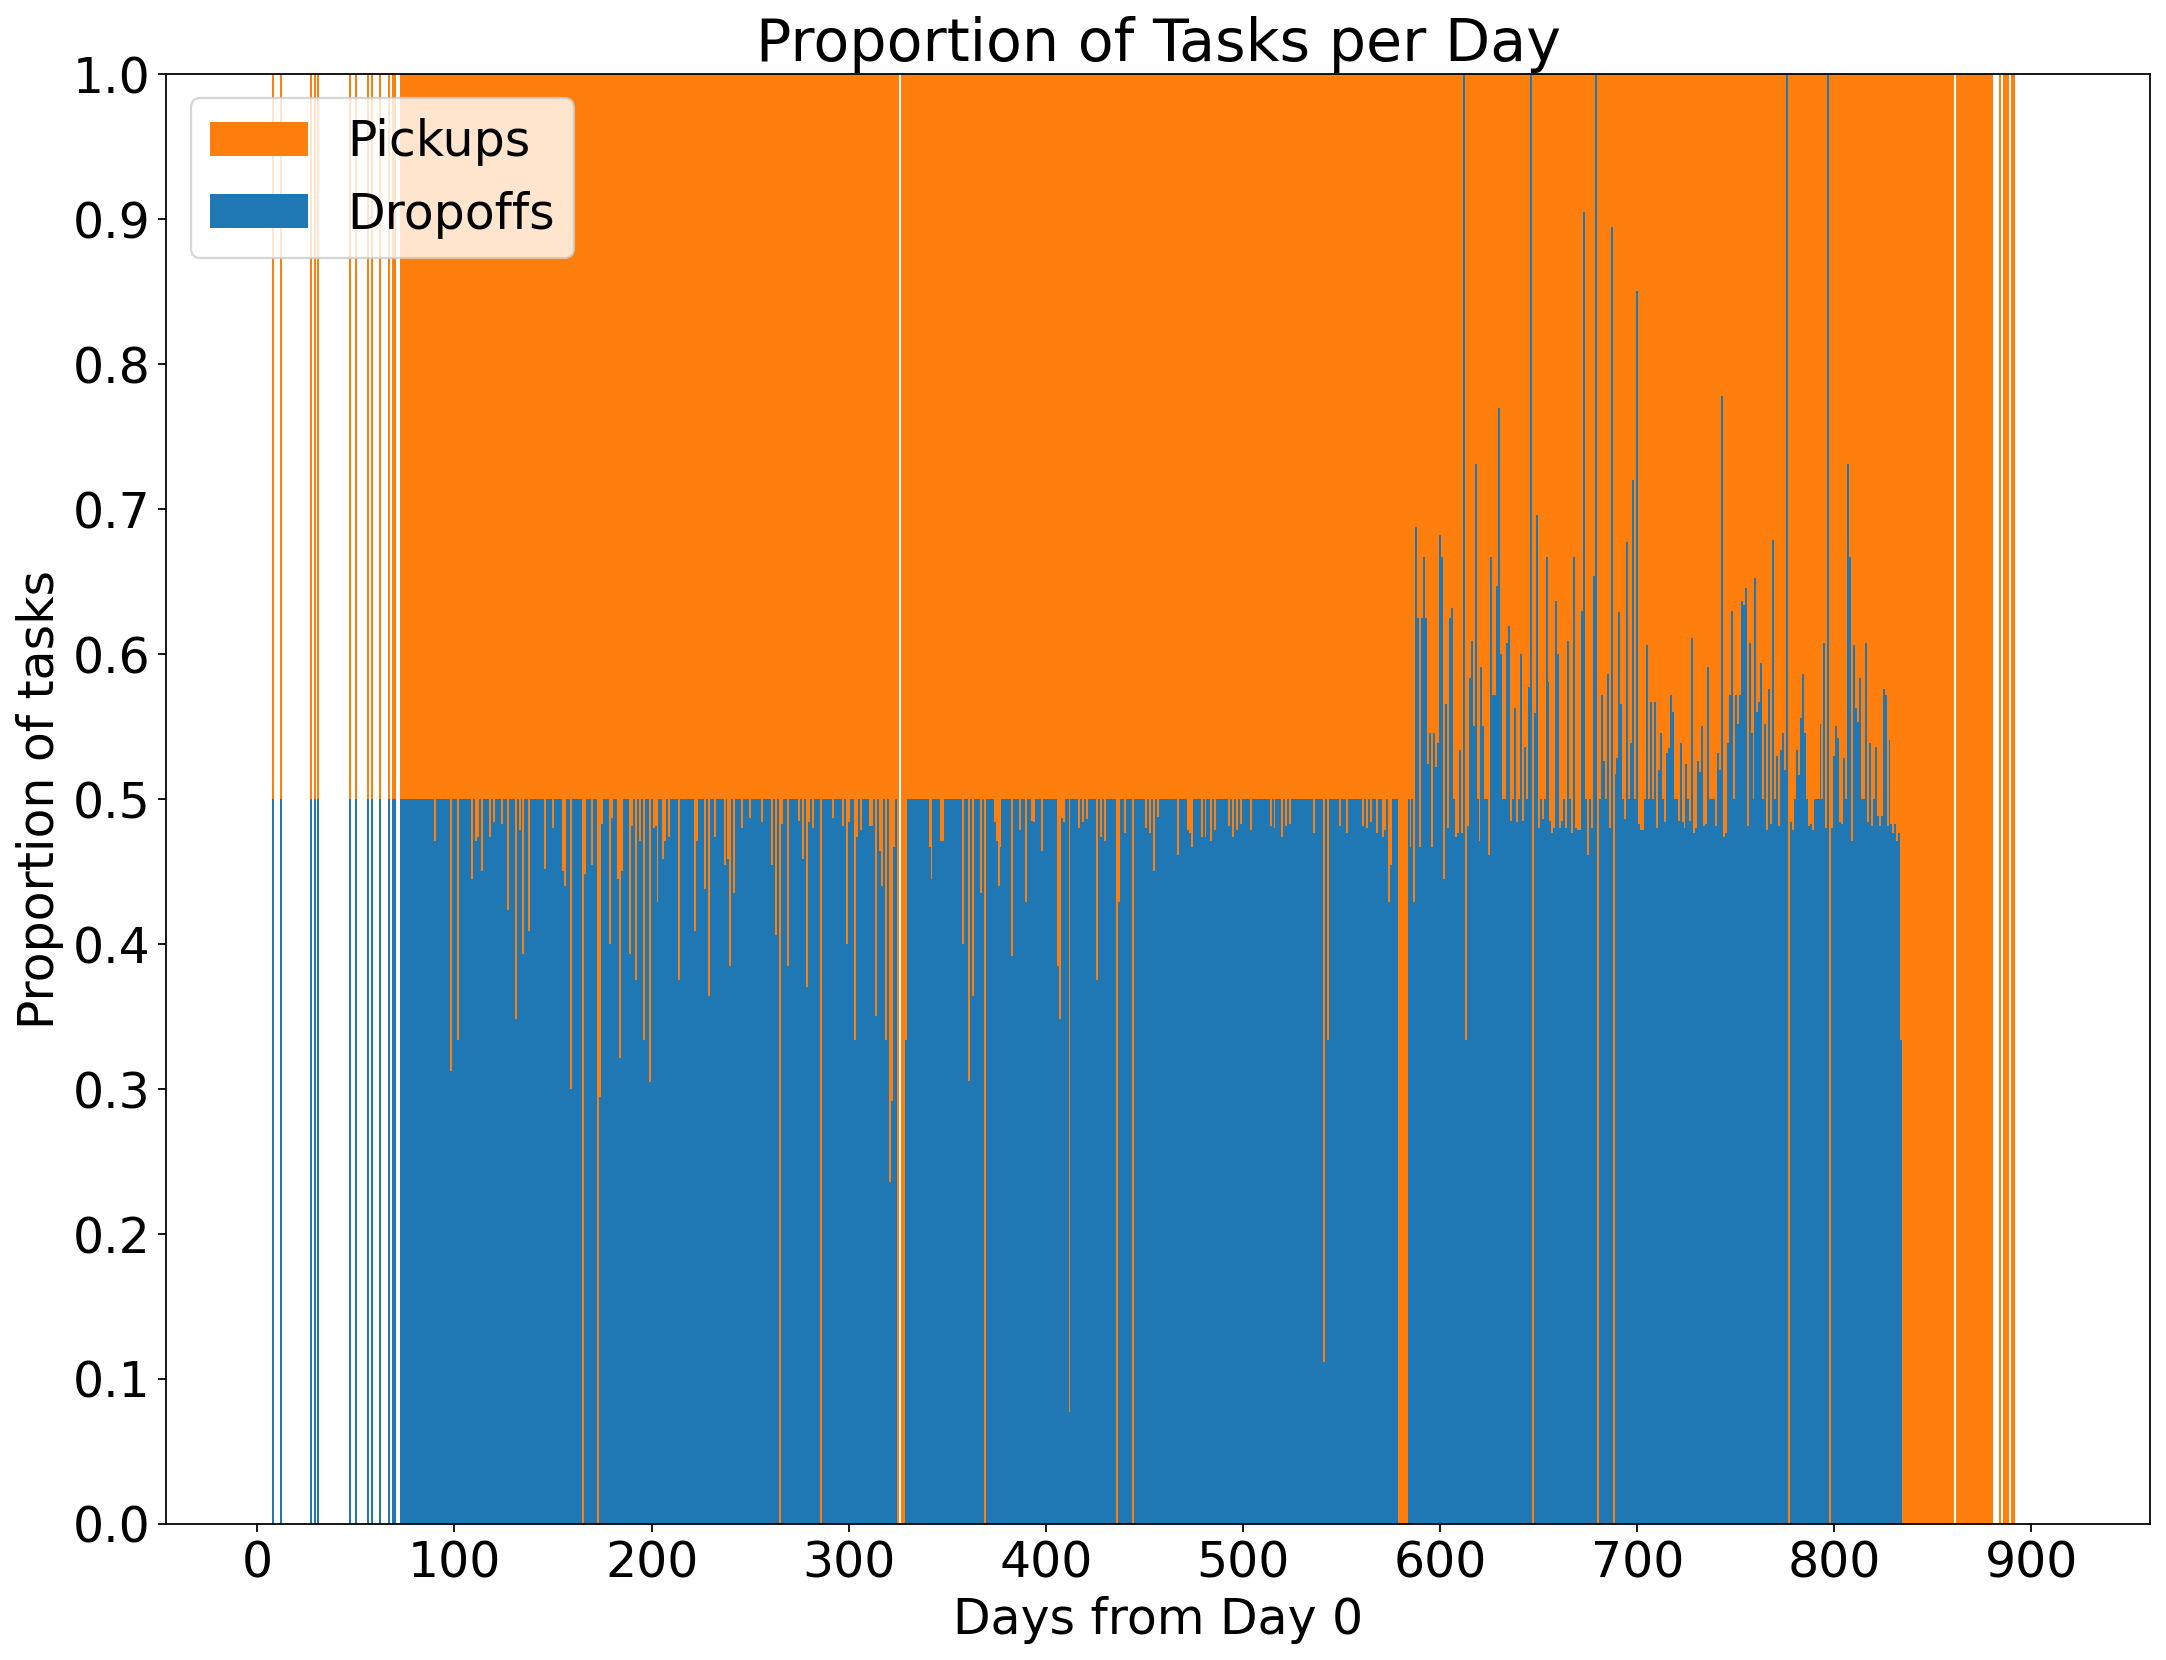

In [5]:
fc.print_log("Start with Stage 1a")
#dict_tours_temp = copy.deepcopy(dict_tours)
dict_tours_temp = dict_tours
moves_possible = True
move_count = 0
loop_count = 0
step_count = 0
dict_statistic = {0: solution_initial.total_distance}


fc.print_log("Start Moves")
while moves_possible and loop_count < 1000:
    move_made = False
    for depot in dict_depots:
        for day_org in list_days:

            #see if there are too many pickups in one job
            tour_org = dict_tours_temp[depot][day_org]

            if tour_org.total_pickups > tour_org.total_dropoffs:
                if tour_org.worst_edge_pickup != '':
                    move_job = tour_org.worst_edge_pickup

                    #see if there is space for a pickup, and check if it works with the earliest pickup date of the job
                    for day_new in list_days:
                        tour_new = dict_tours_temp[depot][day_new]
                        if tour_new.total_pickups < tour_new.total_dropoffs\
                                and move_job.end > day_new:

                            distance_delta = sa.reassign_pickup(tour_org,tour_new,move_job)

                            #adjust move_bol, statistic and leave for loop
                            move_made = True
                            move_count +=1
                            step_count += 1
                            dict_statistic[step_count] = dict_statistic[step_count-1] + distance_delta
                            break

                print("Current: Loop: {} - Moves: {}                                  ".format(loop_count,move_count),end='\r')
                if loop_count > 999: break



    loop_count += 1
    moves_possible = move_made

    print("Current: Loop: {} - Moves: {}                                  ".format(loop_count,move_count),end='\r')

if loop_count > 999:
    fc.print_log("Loopcount exit")

fc.print_log("Final: Loop: {} - Moves: {}".format(loop_count,move_count))

fc.print_log("Done with Moves")
solution_stage1a = cl.Solution(temp_depot,dict_tours_temp,list_days,dev_curr=dict_statistic)

solution_initial.plot_tasks(50)
solution_initial.plot_task_proportion()

solution_stage1a.plot_tasks(50)
solution_stage1a.plot_task_proportion()
fc.print_log("Done with Stage 1a")

In [7]:
print("old distance: %s" % solution_initial.total_distance)
print("new distance: %s" % solution_stage1a.total_distance)

2062687.472639413
2374315.453137417


In [11]:
fc.print_log("Start with Stage 1b")

dict_tours_temp = dict_tours

list_days_reversed = list_days.copy()
list_days_reversed.reverse()


Start with Stage 1b- t: 00:29:13
[16485, 16527, 16528, 16535, 16544, 16555, 16561, 16573, 16581, 16584, 16586, 16588, 16597, 16599, 16601, 16607, 16610, 16612, 16616, 16617, 16618, 16619, 16622, 16626, 16630, 16632, 16633, 16635, 16636, 16637, 16640, 16642, 16644, 16645, 16648, 16649, 16652, 16656, 16658, 16659, 16660, 16661, 16666, 16667, 16668, 16671, 16672, 16673, 16675, 16677, 16678, 16679, 16680, 16682, 16683, 16684, 16688, 16689, 16690, 16691, 16692, 16693, 16694, 16695, 16697, 16698, 16699, 16700, 16701, 16702, 16703, 16704, 16712, 16713, 16714, 16715, 16716, 16717, 16718, 16719, 16720, 16721, 16722, 16723, 16724, 16725, 16726, 16727, 16728, 16729, 16730, 16731, 16732, 16733, 16734, 16735, 16736, 16737, 16738, 16739, 16740, 16741, 16742, 16743, 16744, 16745, 16746, 16747, 16748, 16749, 16750, 16751, 16752, 16753, 16754, 16755, 16756, 16757, 16758, 16759, 16760, 16761, 16762, 16763, 16764, 16765, 16766, 16767, 16768, 16769, 16770, 16773, 16774, 16775, 16776, 16777, 16778, 16779, 

In [ ]:
moves_possible = True
move_count = 0
loop_count = 0

step_count_curr = 0
dict_statistic_curr = {0: solution_stage1a.total_distance}


fc.print_log("Start Moves")
while moves_possible and loop_count < 1000:
    move_made = False
    for depot in dict_depots:
        for day_org in list_days_reversed:

            #see if there are too many pickups in one job
            tour_org = dict_tours_temp[depot][day_org]

            if tour_org.total_dropoffs > tour_org.total_pickups:
                if tour_org.worst_edge_dropoff != '':
                    move_job = tour_org.worst_edge_dropoff

                    #see if there is space for a dropoff, and check if it works with the latest dropoff date of the job
                    for day_new in list_days_reversed:
                        tour_new = dict_tours_temp[depot][day_new]
                        if tour_new.total_dropoffs < tour_new.total_pickups\
                                and move_job.start < day_new:


                            #reassign job
                            distance_delta = sa.reassign_dropoff(tour_org,tour_new,move_job)

                            #adjust move_bol, statistic and leave for loop
                            move_made = True
                            move_count +=1
                            step_count += 1
                            step_count_curr += 1
                            dict_statistic[step_count] = dict_statistic[step_count-1] + distance_delta
                            dict_statistic[step_count_curr] = dict_statistic[step_count]
                            break

                print("Current: Loop: {} - Moves: {}                                  ".format(loop_count,move_count),end='\r')
                if loop_count > 999: break



    loop_count += 1
    moves_possible = move_made

    print("Current: Loop: {} - Moves: {}                                  ".format(loop_count,move_count),end='\r')

if loop_count > 999:
    fc.print_log("Loopcount exit")

fc.print_log("Final: Loop: {} - Moves: {}".format(loop_count,move_count))

fc.print_log("Done with Moves")
#create new solutions
solution_stage1b = cl.Solution(temp_depot,dict_tours_temp,list_days,\
                               dev_curr=dict_statistic_curr,dev_tot_old=dict_statistic)


solution_stage1b.plot_tasks(50)
solution_stage1b.plot_task_proportion()
fc.print_log("Done with Stage 1b")



In [5]:
solution_stage1b.plot_developement()
solution_stage1b.plot_developement(total=True)